# Battle of the Neighborhoods Final Project


In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

import requests
import urllib.request
import time
from bs4 import BeautifulSoup
from urllib.request import urlopen
from PIL import Image
import io

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


In [2]:
!pip install -U selenium


Requirement already up-to-date: selenium in c:\users\jaime\anaconda3\lib\site-packages (3.141.0)


In [3]:
import selenium
import os
from selenium import webdriver

### To begin we scrape the information we need on cities in Europe. The Wikipedia page we use has a list of 79 cities within Europe that we will fill our dataframe with

In [4]:
url = 'https://en.wikipedia.org/wiki/List_of_urban_areas_in_the_European_Union'
html = urlopen(url) 
soup = BeautifulSoup(html, 'html.parser')
table = soup.find('table', {'class': "wikitable sortable mw-collapsible"})

### We parse through the html and extract the information we need

In [5]:
cities = [] 
countries = []

tbodys = table.find_all('tbody')
for tbody in tbodys:
    rows = table.find_all('tr')
    for row in rows:
        cells = row.find_all('td')
        if len(cells) > 1:
            cities.append(str(cells[1].text.strip()))
            countries.append(str(cells[3].text.strip()))

### We store our information in a dataframe called df, which has each city and its country 

In [6]:
df = pd.DataFrame({
    'City': cities,
    'Country': countries
    })
print('Shape of dataframe df: ', df.shape)
df.head(10)

Shape of dataframe df:  (79, 2)


,City,Country
0,Paris,France
1,Ruhr (multiple cities),Germany
2,Madrid,Spain
3,Milan,Italy
4,Barcelona,Spain
5,Berlin,Germany
6,Naples,Italy
7,Athens,Greece
8,Rome,Italy
9,Rotterdam–The Hague,Netherlands


### Cleaning up the cities column to only contain name of the City (removing any parentheses). We also add the Latitude and Longitude columns to the dataframe

In [7]:
df['City'] = df['City'].str.replace(r"\(.*\)","")
df['Latitude'] = None
df['Longitude'] = None
df

,City,Country,Latitude,Longitude
0,Paris,France,None,None
1,Ruhr,Germany,None,None
2,Madrid,Spain,None,None
3,Milan,Italy,None,None
4,Barcelona,Spain,None,None
5,Berlin,Germany,None,None
6,Naples,Italy,None,None
7,Athens,Greece,None,None
8,Rome,Italy,None,None
9,Rotterdam–The Hague,Netherlands,None,None


### Now we'll get the coordinates of each City and add them to our dataframe

In [8]:
for row in df.itertuples():
    # Getting address of City
    address = '{}, {}'.format(row[1], row[2])
    geolocator = Nominatim(user_agent="explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    df.at[row[0], 'Latitude'] = latitude
    df.at[row[0], 'Longitude'] = longitude
df.head(10)

,City,Country,Latitude,Longitude
0,Paris,France,48.8567,2.35146
1,Ruhr,Germany,51.5175,7.14392
2,Madrid,Spain,40.4167,-3.70358
3,Milan,Italy,45.4668,9.1905
4,Barcelona,Spain,41.3829,2.17743
5,Berlin,Germany,52.517,13.3889
6,Naples,Italy,40.8359,14.2488
7,Athens,Greece,37.9839,23.7283
8,Rome,Italy,41.8933,12.4829
9,Rotterdam–The Hague,Netherlands,51.9561,4.43927


### Here we set our Foursquare credentials we will need to get the Venue information for each city in our dataframe

In [9]:
CLIENT_ID = 'LV3UMOYKQA3WRTV0VTAV0HMAAWNX2OZM20R2HIEVWSHIBDNM' # your Foursquare ID
CLIENT_SECRET = '53X5Y3AN4GTPN002MG0I525HOAVTSXM45MM3QMFLNKIDQ1JU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your Foursquare credentails are set!')

Your Foursquare credentails are set!


### Using the results from our call to the Foursquare API, we'll create a new dataframe called nearby_venues that contains the first 100 venues from the center of Rome within a 500m radius

In [10]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
latitude = float(df[df['City'] == 'Rome']['Latitude'])
longitude = float(df[df['City'] == 'Rome']['Longitude'])
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
results = requests.get(url).json()


In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [12]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(20)

,name,categories,lat,lng
0,Piazza del Campidoglio,Plaza,41.893321,12.482956
1,Foro di Cesare,Historic Site,41.894128,12.485232
2,Terrazza delle Quadrighe,Scenic Lookout,41.894346,12.483336
3,Foro di Traiano,Historic Site,41.894729,12.484871
4,Capitoline Hill (Campidoglio),Scenic Lookout,41.893462,12.483588
5,Musei Capitolini,Art Museum,41.893343,12.482885
6,Teatro Della Cometa,Theater,41.893399,12.481593
7,Tempio di Vespasiano e Tito,Temple,41.892494,12.483688
8,Arco di Settimio Severo,Monument / Landmark,41.892894,12.484658
9,Terrazza Caffarelli,Scenic Lookout,41.892589,12.481666


### Let's take a closer at what type these venues are

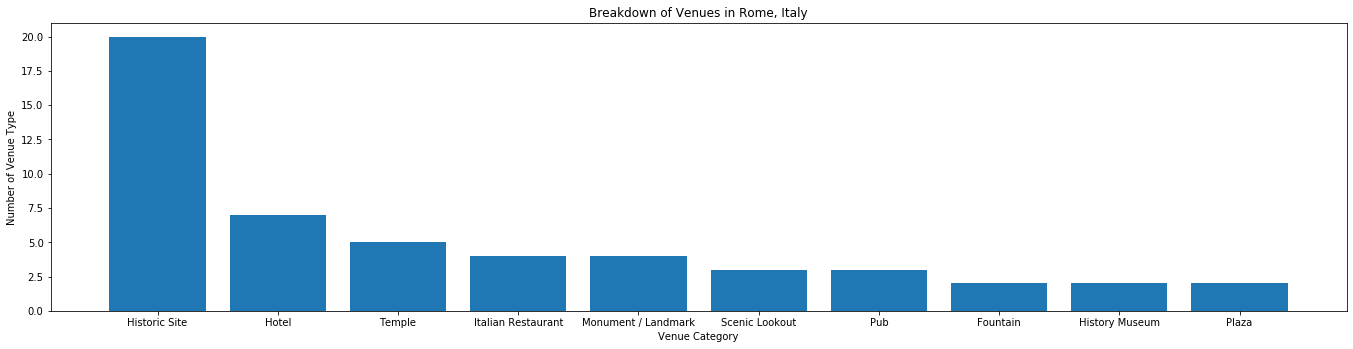

In [13]:
counts = nearby_venues.groupby('categories').count().sort_values('name',ascending=False).head(10)
fig = plt.figure()
ax = fig.add_axes([0,0,3,1])
venues = counts.index
nums = counts['name']
ax.set_xlabel('Venue Category')
ax.set_ylabel('Number of Venue Type')
ax.set_title('Breakdown of Venues in Rome, Italy')
ax.bar(venues, nums)
plt.show()


### Now let's visualize all of these venues in Rome. Clearly, the 'Historic Site', 'Monument / Landmark', 'Temple', and 'Plaza' categories make up most of the venues in central Rome. 

In [14]:
# create map of New York using latitude and longitude values
map_rome = folium.Map(location=[latitude, longitude], zoom_start=15)

# add markers to map
for lat, lng, name, category in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name'], nearby_venues['categories']):
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        color='blue',
        popup=label,
        fill=True,
        fill_color='#3186cc',
        fill_opaCity=0.7,
        parse_html=False).add_to(map_rome)  
    
map_rome

### Now we'll create the getNearbyVenues function to repeat the steps above with all cities in our df dataframe

In [15]:
def getNearbyVenues(cities, countries, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, country, lat, lng in zip(cities, countries, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            country,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City',
                             'Country',
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
europe_venues = getNearbyVenues(cities=df['City'],
                                countries=df['Country'],
                                latitudes=df['Latitude'],
                                longitudes=df['Longitude']
                                )
print('Done! All venues have been recorded in the europe_venues dataframe.')

Done! All venues have been recorded in the europe_venues dataframe.


In [17]:
print(europe_venues.shape)
europe_venues.head(20)

(5813, 8)


,City,Country,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Paris,France,48.856697,2.351462,Place de l'Hôtel de Ville – Esplanade de la Li...,48.856925,2.351412,Plaza
1,Paris,France,48.856697,2.351462,Parc Rives de Seine,48.855510,2.351419,Park
2,Paris,France,48.856697,2.351462,Berges de Seine – Rive droite,48.855131,2.352289,Pedestrian Plaza
3,Paris,France,48.856697,2.351462,L'Alsacien,48.858275,2.350381,Alsatian Restaurant
4,Paris,France,48.856697,2.351462,BHV Marais,48.857312,2.353633,Department Store
5,Paris,France,48.856697,2.351462,Maison Aleph,48.857348,2.354873,Pastry Shop
6,Paris,France,48.856697,2.351462,Square de la Tour Saint-Jacques,48.857882,2.348757,Park
7,Paris,France,48.856697,2.351462,Tour Saint-Jacques,48.858031,2.348875,Historic Site
8,Paris,France,48.856697,2.351462,BHV Marais – L'Homme,48.857752,2.353908,Men's Store
9,Paris,France,48.856697,2.351462,Galerie Azzedine Alaïa,48.857545,2.355217,Art Gallery


### Let's take a look at all of the unique venue categories that the cities have to offer

In [18]:
print('There are {} uniques categories.'.format(len(europe_venues['Venue Category'].unique())))
europe_venues['Venue Category'].unique()

There are 345 uniques categories.


array(['Plaza', 'Park', 'Pedestrian Plaza', 'Alsatian Restaurant',
       'Department Store', 'Pastry Shop', 'Historic Site', "Men's Store",
       'Art Gallery', 'Furniture / Home Store', 'Gay Bar',
       'French Restaurant', 'Café', 'Cocktail Bar',
       'Portuguese Restaurant', 'Auvergne Restaurant', 'Dessert Shop',
       'Ice Cream Shop', 'Coffee Shop', 'Flower Shop',
       'Seafood Restaurant', 'Deli / Bodega', 'Theater',
       'Sushi Restaurant', 'Church', 'Miscellaneous Shop', 'Restaurant',
       'Pub', 'Tea Room', 'Chocolate Shop', 'Cupcake Shop',
       'Clothing Store', 'Hotel', 'Scenic Lookout', 'Souvenir Shop',
       'Art Museum', 'Creperie', 'Bar', 'Bookstore', 'Wine Bar',
       'Italian Restaurant', 'Pet Store', 'Lounge', 'Arts & Crafts Store',
       'Optical Shop', 'Burger Joint', 'Memorial Site', 'Bistro',
       'Salon / Barbershop', 'Gourmet Shop', 'Beer Store',
       'Scandinavian Restaurant', 'Corsican Restaurant',
       'Cultural Center', 'Burgundian Res

## Now that we have all of the information we need, we can start using machine learning to predict what cities we should visit next based on specificed preferences. 
### We start by creating a dataframe that contains each city with the percentage of each venue category that makes up that city (within 500m of the city center)

In [19]:
# one hot encoding
europe_onehot = pd.get_dummies(europe_venues[['Venue Category']], prefix="", prefix_sep="")

# add City column back to dataframe
europe_onehot['City'] = europe_venues['City'] 

# move City column to the first column
fixed_columns = [europe_onehot.columns[-1]] + list(europe_onehot.columns[:-1])
europe_onehot = europe_onehot[fixed_columns]
europe_grouped = europe_onehot.groupby('City').mean()
europe_grouped.head(10)

,Accessories Store,African Restaurant,Airport Service,Alsatian Restaurant,American Restaurant,Amphitheater,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Bavarian Restaurant,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Bougatsa Shop,Boutique,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burgundian Restaurant,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Camera Store,Candy Store,Capitol Building,Casino,Castle,Caucasian Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Library,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Creperie,Cretan Restaurant,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Emilia Restaurant,Empanada Restaurant,English Restaurant,Escape Room,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fish Taverna,Fishing Store,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,Gelato Shop,General College & University,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health Food Store,Herbs & Spices Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Hotel Pool,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kafenio,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Ligurian Restaurant,Lingerie Store,Liquor Store,Lounge,Magirio,Marijuana Dispensary,Market,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Modern Greek Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Neighborhood,Nightclub,Nightlife Spot,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Ouzeri,Paella Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Photography Studio,Piadineria,Pie Shop,Piedmontese Restaurant,Piercing Parlor,Pizza Place,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Post Office,Print Shop,Provençal Restaurant,Pub,Public Art,Radio Station,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Resort,Restaurant,River,Road,Rock Club,Roman Restaurant,Romanian Restaurant,Roof Deck,Rooftop Bar,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinav

### Here we will initiate a sample user that we'll use to make predictions on where this person should travel next

In [20]:
columns = europe_grouped.columns
data = np.zeros((1, len(columns)))
user = pd.DataFrame(data, columns=columns)
user

,Accessories Store,African Restaurant,Airport Service,Alsatian Restaurant,American Restaurant,Amphitheater,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Bavarian Restaurant,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Bougatsa Shop,Boutique,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burgundian Restaurant,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Camera Store,Candy Store,Capitol Building,Casino,Castle,Caucasian Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Library,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Creperie,Cretan Restaurant,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Emilia Restaurant,Empanada Restaurant,English Restaurant,Escape Room,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fish Taverna,Fishing Store,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,Gelato Shop,General College & University,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health Food Store,Herbs & Spices Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Hotel Pool,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kafenio,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Ligurian Restaurant,Lingerie Store,Liquor Store,Lounge,Magirio,Marijuana Dispensary,Market,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Modern Greek Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Neighborhood,Nightclub,Nightlife Spot,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Ouzeri,Paella Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Photography Studio,Piadineria,Pie Shop,Piedmontese Restaurant,Piercing Parlor,Pizza Place,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Post Office,Print Shop,Provençal Restaurant,Pub,Public Art,Radio Station,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Resort,Restaurant,River,Road,Rock Club,Roman Restaurant,Romanian Restaurant,Roof Deck,Rooftop Bar,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinav

### Now we need to fill out the preferences of the user, and we'll base it off my own personal preferences. One of my favorite places I've visited is Rome for its historic sites, landmarks, plazas, and temples, art galleries, and churches, among other things. So, for each of these categories, we'll place a 1.0 in its corresponding cell to indicate that this category is something we are interesed in

In [21]:
user.at[0, ('Historic Site', 'Monument / Landmark', 'Temple', 'Plaza', 'Church', 'Art Gallery')] = 1
user

,Accessories Store,African Restaurant,Airport Service,Alsatian Restaurant,American Restaurant,Amphitheater,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Bavarian Restaurant,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Bougatsa Shop,Boutique,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burgundian Restaurant,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Camera Store,Candy Store,Capitol Building,Casino,Castle,Caucasian Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Library,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Creperie,Cretan Restaurant,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Emilia Restaurant,Empanada Restaurant,English Restaurant,Escape Room,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fish Taverna,Fishing Store,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,Gelato Shop,General College & University,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health Food Store,Herbs & Spices Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Hotel Pool,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kafenio,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Ligurian Restaurant,Lingerie Store,Liquor Store,Lounge,Magirio,Marijuana Dispensary,Market,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Modern Greek Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Neighborhood,Nightclub,Nightlife Spot,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Ouzeri,Paella Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Photography Studio,Piadineria,Pie Shop,Piedmontese Restaurant,Piercing Parlor,Pizza Place,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Post Office,Print Shop,Provençal Restaurant,Pub,Public Art,Radio Station,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Resort,Restaurant,River,Road,Rock Club,Roman Restaurant,Romanian Restaurant,Roof Deck,Rooftop Bar,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinav

### Now we can use machine learning to predict what our top 10 cities to visit next will be, based on our preferences. We do this by implementing a content-based Recommender System that uses a user's preferences combined with attributes of anything (in our case cities) to recommend other things for the user. 

In [22]:
matrix = user.dot(europe_grouped.T).T
matrix.columns = ['Score']
matrix.head(11)
new = df.join(matrix, on='City')
new = new.sort_values('Score', ascending=False).reset_index(drop=True)
cols = new.columns.tolist()
cols = cols[-1:] + cols[:-1]
new = new[cols]
new.head(11)

,Score,City,Country,Latitude,Longitude
0,0.438356,Rome,Italy,41.8933,12.4829
1,0.333333,Ruhr,Germany,51.5175,7.14392
2,0.227273,Palermo,Italy,38.1112,13.3524
3,0.178571,Hamburg,Germany,53.5438,10.0099
4,0.160000,Lyon,France,45.7578,4.83201
5,0.150000,Genoa,Italy,44.4073,8.93386
6,0.150000,Bologna,Italy,44.4937,11.343
7,0.150000,Florence,Italy,43.7699,11.2556
8,0.144928,Catania,Italy,37.5022,15.0874
9,0.140000,Seville,Spain,37.3886,-5.99534


### Thanks to our new dataframe, we can easily see what our top 10 cities to visit next are. Rome would be first on the list since the preferences are based on the venues I loved when visited, but after that it seems that Ruhr, Germany would be the next best place to visit! 

### Finally, we can also explore what the top 5 venues in each city are, in case we would like to see what is popular in each city, and base our search on new categories! 

In [23]:
num_top_venues = 5
for hood in europe_grouped.index:
    #print("----"+hood+"----")
    temp = europe_grouped[europe_grouped.index == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})

In [24]:
# Function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Citys_venues_sorted = pd.DataFrame(columns=columns)
Citys_venues_sorted['City'] = europe_grouped.index

for ind in np.arange(europe_grouped.shape[0]):
    Citys_venues_sorted.iloc[ind, 1:] = return_most_common_venues(europe_grouped.iloc[ind, :], num_top_venues)

Citys_venues_sorted.head(5)

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aachen,Bakery,Drugstore,Plaza,Ice Cream Shop,Café,Sushi Restaurant,Italian Restaurant,Coffee Shop,Cocktail Bar,German Restaurant
1,Amsterdam,Bar,Hotel,Italian Restaurant,Coffee Shop,Bakery,Burger Joint,Cocktail Bar,Marijuana Dispensary,Pub,Museum
2,Antwerp,Bar,Coffee Shop,Cocktail Bar,Italian Restaurant,Plaza,Restaurant,Bookstore,Belgian Restaurant,Pub,Sushi Restaurant
3,Athens,Bar,Café,Coffee Shop,Hotel,Theater,Greek Restaurant,Falafel Restaurant,Bookstore,Dessert Shop,Magirio
4,Barcelona,Tapas Restaurant,Plaza,Ice Cream Shop,Bar,Spanish Restaurant,Hotel,Italian Restaurant,Coffee Shop,Pizza Place,Vegetarian / Vegan Restaurant


# Thank you!